# Test further train Spanish model (to compare)

In [1]:
import gc
import json
import os
import random
import re
import time
from tqdm import tqdm

import keras
from keras.activations import tanh as Tanh
from keras.layers import Activation, Add, Dense, Embedding, Masking
from keras.layers import Input, SimpleRNN, LSTM, GRU
from keras.models import Model, load_model
from keras import regularizers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils import to_categorical 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import nltk
import numpy as np
import tensorflow as tf
import string, unicodedata
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

keras.backend.set_epsilon(1e-16)
keras.__version__
nltk.download('punkt')
nltk.download('wordnet')

np.random.seed(42)
random.seed(12345)
tf.set_random_seed(1234)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
keras.backend.get_session().run(tf.global_variables_initializer())

Using TensorFlow backend.


In [2]:
# DATASET PATHS
fasttext_enbeddings = "../../data/embeddings/fasttext/multi/wiki.multi.es.vec"

TRAIN_SENTENCES = "../../data/semeval/es/es-train-sentences.txt"
TRAIN_LABELS = "../../data/semeval/es/es-train-labels.txt"
TEST_SENTENCES = "../../data/semeval/es/es-test-sentences.txt"
TEST_LABELS = "../../data/semeval/es/es-test-labels.txt"

for link_ in [fasttext_enbeddings, TRAIN_SENTENCES, TRAIN_LABELS, TEST_SENTENCES, TEST_LABELS]:
    if not os.path.isfile(link_):
        print(f"`{link_}` NOT FOUND!")

In [3]:
# READ DATASET FUNCTIONS
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def preprocess_text(text):
    text = denoise_text(text)
    text = replace_contractions(text)
    return text

def split_into_words(text):
    return nltk.word_tokenize(text)

""" WORD LEVEL - NORMALIZATION """

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word, comma=".")
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('spanish'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer("spanish")
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
#     words = remove_stopwords(words)
    words = stem_words(words)
    return words

def read_labels(file_path):
    with open(file_path, "r") as labs_f:
        labels = [float(l.strip('\n')) for l in labs_f]
    return labels

def to_categorical_fractions(labels):
    # deal with fractional annotations in labels
    categories_num = to_categorical(labels).shape[1]
    results = []
    for lab in labels:
        major_label = int(lab)
        minor_label = major_label + 1
        minor_weight = lab - major_label
        major_weight = 1 - minor_weight
        cur_result = np.zeros(categories_num)
        cur_result[major_label] = major_weight
        if minor_weight > 0:
            cur_result[minor_label] = minor_weight
        results.append(cur_result)
    return np.array(results)

def read_linear_dataset(dataset_path):
    # return array of sentense pairs and vocabulary
    with open(dataset_path, "r") as ds_f:
        result = [[],[]]
        for line in ds_f:
            cur_line = line.split("\t")
            assert len(cur_line) == 2, f"error in cur_line (len {len(cur_line)}): {cur_line}"
            sent1 = cur_line[0].strip(" ")
            sent1 = preprocess_text(sent1)
            sent1 = split_into_words(sent1)
            sent1 = normalize(sent1)
            result[0].append(sent1)
            sent2 = preprocess_text(cur_line[1].strip("\n").strip(" "))
            sent2 = split_into_words(sent2)
            sent2 = normalize(sent2)
            result[1].append(sent2)
    return result

def get_embeddings(embeddings_path, words_num=None):
    # adapted to FastText embeddings
    with open(embeddings_path, "r") as emb_f:
        word2vec = {}
        for i, line in enumerate(emb_f):
            line = line.strip("\n").split(" ")
            if i == 0:
                total_word_num = int(line[0])
                words_num = words_num if total_word_num > words_num else total_word_num
                continue
            if line[0] in word2vec:
                print(line[0] + " is in vocab!. Vocab len: " + str(len(word2vec)))
            word2vec[line[0]] = np.asarray(line[1:], dtype='float32')
            if i == words_num:
                break
    return word2vec

def minimize_embeddings(data, principal_comp_fraction=0.85):
    """
    1. Prepare data for PCA
    2. PCA transformation
    3. Normalize features for training
    Note: first sampleshould be zeros
    """
    first_row = data[0]
    data = np.array(data[1:])
    data = StandardScaler().fit_transform(data)
    pca = PCA(principal_comp_fraction)
    data = pca.fit_transform(data)
    data = MaxAbsScaler().fit_transform(data)
    feats_num = data.shape[1]
    return np.vstack((first_row[:feats_num], data))

### READ DATASET

In [4]:
MAX_SEQUENCE_LENGTH = 100
VALIDATION_SPLIT = 0.25
EMBEDDING_DIM = 300
voc_words_num = 200000
# Spanish corpus was shuffled before splitting into train and test sets

# read embeddings -> dict(word : vector)
embeddings_index = get_embeddings(fasttext_enbeddings, words_num=voc_words_num)
# read labels
train_labels = read_labels(TRAIN_LABELS)
test_labels = read_labels(TEST_LABELS)
test_labels = test_labels[:350]

split_indx = int((1 - VALIDATION_SPLIT) * len(train_labels))

train_labels = to_categorical_fractions(train_labels)
val_labels = train_labels[split_indx:, :]
train_labels = train_labels[:split_indx, :]
test_labels = to_categorical_fractions(test_labels)
print(f"train_labels - shape: {train_labels.shape}, type {type(train_labels)}")
print(f"test_labels - shape: {test_labels.shape}, type {type(test_labels)}")
print(f"val_labels - shape: {val_labels.shape}, type {type(val_labels)}")
print(f"embeddings_index - type {type(embeddings_index)} - length {len(embeddings_index)}")
print(f"train_label example - {train_labels[2]}")
print(f"test_label example - {test_labels[2]}")
print(f"val_labels example - {val_labels[2]}")

# read dataset -> list(sentence_str1, sentence_str2)
train_dataset = read_linear_dataset(TRAIN_SENTENCES)
test_dataset = read_linear_dataset(TEST_SENTENCES)
test_dataset = [test_dataset[0][:350], test_dataset[1][:350]]

print(f"train_dataset - type: {type(train_dataset)}, len: {len(train_dataset)}")
print(f"test_dataset - type: {type(test_dataset)}, len: {len(test_dataset)}")
print(f"\ntrain_dataset - 5 first sentence pair lengths: ", end="")
print([(len(train_dataset[0][i]), len(train_dataset[1][i])) for i in range(5)])
print(f"test_dataset - 5 first sentence pair lengths: ", end="")
print([(len(test_dataset[0][i]), len(test_dataset[1][i])) for i in range(5)])

print("\n- train_dataset example pair -")
print(train_dataset[0][0])
print(train_dataset[1][0])
print("- test_dataset example pair -")
print(test_dataset[0][8])
print(test_dataset[1][8])

tokenizer = Tokenizer(filters="", lower=False, split=' ')
tokenizer.fit_on_texts(list(embeddings_index.keys()))

sequences_1 = tokenizer.texts_to_sequences(train_dataset[0])
sequences_2 = tokenizer.texts_to_sequences(train_dataset[1])
test_sequences_1 = tokenizer.texts_to_sequences(test_dataset[0])
test_sequences_2 = tokenizer.texts_to_sequences(test_dataset[1])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(list(word_index.items())[:10])

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')

assert len(data_1) == len(data_2)
assert len(test_data_1) == len(test_data_2)

data = [data_1[:split_indx], data_2[:split_indx]]
val_data = [data_1[split_indx:], data_2[split_indx:]]
test_data = [test_data_1, test_data_2]
print(f"Shapes of train data tensors: {data[0].shape}, {data[0].shape}")
print(f"Shapes of test data tensors: {test_data[0].shape}, {test_data[0].shape}")
print(f"Shapes of validation data tensors: {val_data[0].shape}, {val_data[0].shape}")
print(f"Shape of train label tensor: {train_labels.shape}")
print(f"Shape of test label tensor: {test_labels.shape}")
print(f"Shape of val label tensor: {val_labels.shape}")

print(data[0][0])
print(data[1][0])

train_labels - shape: (1083, 6), type <class 'numpy.ndarray'>
test_labels - shape: (350, 6), type <class 'numpy.ndarray'>
val_labels - shape: (361, 6), type <class 'numpy.ndarray'>
embeddings_index - type <class 'dict'> - length 200000
train_label example - [0.5 0.5 0.  0.  0.  0. ]
test_label example - [0.  0.  0.  0.2 0.8 0. ]
val_labels example - [0. 1. 0. 0. 0. 0.]
train_dataset - type: <class 'list'>, len: 2
test_dataset - type: <class 'list'>, len: 2

train_dataset - 5 first sentence pair lengths: [(10, 10), (36, 51), (22, 19), (20, 12), (42, 51)]
test_dataset - 5 first sentence pair lengths: [(45, 31), (35, 17), (8, 10), (40, 30), (25, 45)]

- train_dataset example pair -
['el', 'part', 'de', 'voleibol', 'esta', 'en', 'curs', 'entre', 'las', 'dam']
['mujer', 'particip', 'en', 'las', 'final', 'de', 'la', 'competent', 'de', 'tenis']
- test_dataset example pair -
['un', 'hombr', 'muestr', 'algun', 'rop', 'mientr', 'usa', 'zapat', 'azul', '.']
['un', 'hombr', 'y', 'una', 'muj', 'est

In [5]:
# embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [6]:
embedding_matrix_pca = minimize_embeddings(embedding_matrix,
                                           principal_comp_fraction=50)
print(embedding_matrix_pca.shape)

(200001, 50)


In [7]:
embedding_matrix = embedding_matrix_pca
EMBEDDING_DIM = embedding_matrix.shape[1]
del embedding_matrix_pca
print(embedding_matrix.shape)

(200001, 50)


## Model

In [5]:
# Measure
def pearson_r(y_true, y_pred):
    # https://github.com/WenYanger/Keras_Metrics/blob/master/PearsonCorr.py
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)


## Experiments

### No retrain

In [6]:
model_path = "/media/invictus/TowerSSD/master-thesis/github/notebooks/v2_larger-batch_smaller-network_aligned-embeddings/es-model/6-es-model/weights/weights.epoch_240.valloss_1.68.valpearson_0.27.hdf5"
model = load_model(model_path, custom_objects={"pearson_r": pearson_r})

In [7]:
test_loss, test_metrics = model.evaluate(x=test_data, y=test_labels, batch_size=5)
print(test_loss)
print(test_metrics)

350/350 [==============================] - 4s 12ms/step
1.684213559968131
0.2526943923905492


### Training further network for Spanish

In [8]:
# setup
BASE_DIR = "es-model-futher-training/6-en-es-model"
if not os.path.isdir(f"{BASE_DIR}/weights"):
    os.makedirs(f"{BASE_DIR}/weights")

params = {
    "output_vector_size": 50,
    "batch_size": 128,
    "epochs_num": 250,
    "learning_rate": 0.05,
    "momentum": 0,
    "decay": 0.001,
    "regularization": 0.001
}

if not os.path.isdir(f"{BASE_DIR}/weights"):
    os.makedirs(f"{BASE_DIR}/weights")

# loggers
ckpt_file = f"{BASE_DIR}" + "/weights/weights.epoch_{epoch:02d}.valloss_{val_loss:.2f}.valpearson_{val_pearson_r:.02f}.hdf5"
checkpoint_logger = keras.callbacks.ModelCheckpoint(
    ckpt_file, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False,
    mode='auto', period=1)
tensorboard_logger = keras.callbacks.TensorBoard(
    log_dir=f'{BASE_DIR}/logs', write_graph=True, write_images=True, update_freq='epoch')
csv_logger = keras.callbacks.CSVLogger(f'{BASE_DIR}/training-log.csv')

# before training evaluation
print("Initial evaluation")
zero_loss, zero_measure = model.evaluate(x=data, y=train_labels, batch_size=params["batch_size"], verbose=1)
val_zero_loss, val_zero_measure = model.evaluate(x=val_data, y=val_labels, batch_size=params["batch_size"], verbose=1)
test_zero_loss, test_zero_measure = model.evaluate(x=test_data, y=test_labels, batch_size=params["batch_size"], verbose=1)

print(f"initial:\nloss: {zero_loss}, val: {val_zero_loss}, test: {test_zero_loss}",
      f"\nmeasure: {zero_measure}, val: {val_zero_measure}, test: {test_zero_measure}")
with open(f"{BASE_DIR}/zero_epoch_loss_measure.txt", "w") as out_f:
    out_f.write(f"loss\ntrain: {zero_loss}\nval: {val_zero_loss}\ntest: {test_zero_loss}")
    out_f.write(f"\n\nmeasure\ntrain: {zero_measure}\nval: {val_zero_measure}\ntest {test_zero_measure}")

# train
start_time = time.time()
print(f"\n- Re-training LSTM Englich model for Spanish")
model_history = model.fit(data, train_labels, validation_data=(val_data, val_labels),
                          epochs=params["epochs_num"], verbose=2,
                          batch_size=params["batch_size"],
                          callbacks=[checkpoint_logger, csv_logger])

print("max val_pearson_r - {} at {}".format(
    np.max(model_history.history['val_pearson_r']),
    np.argmax(model_history.history['val_pearson_r'])+1))
    
elapsed_time = int((time.time() - start_time) / 60)

print(f"time spent - total {elapsed_time} min")

# save json dumps of experiment
OUT_PATH = f"{BASE_DIR}/en-model-retraining_histories-for-plots.json"
with open(OUT_PATH, 'w') as outfile:
    json.dump(model_history.history, outfile, indent=4)

Initial evaluation
350/350 [==============================] - 0s 493us/step
initial:
loss: 1.6580534390795594, val: 1.6808857303577116, test: 1.6966096796308245 
measure: 0.29842452929180635, val: 0.2669370906670008, test: 0.250163813659123

- Re-training LSTM Englich model for Spanish
Train on 1083 samples, validate on 361 samples
Epoch 1/250
 - 2s - loss: 1.6582 - pearson_r: 0.2997 - val_loss: 1.6808 - val_pearson_r: 0.2663
Epoch 2/250
 - 2s - loss: 1.6575 - pearson_r: 0.2994 - val_loss: 1.6844 - val_pearson_r: 0.2625
Epoch 3/250
 - 1s - loss: 1.6577 - pearson_r: 0.3014 - val_loss: 1.6791 - val_pearson_r: 0.2684
Epoch 4/250
 - 1s - loss: 1.6586 - pearson_r: 0.3006 - val_loss: 1.6850 - val_pearson_r: 0.2614
Epoch 5/250
 - 1s - loss: 1.6568 - pearson_r: 0.3014 - val_loss: 1.6829 - val_pearson_r: 0.2637
Epoch 6/250
 - 2s - loss: 1.6569 - pearson_r: 0.3007 - val_loss: 1.6839 - val_pearson_r: 0.2626
Epoch 7/250
 - 1s - loss: 1.6574 - pearson_r: 0.3001 - val_loss: 1.6824 - val_pearson_r: 0

Epoch 81/250
 - 1s - loss: 1.6480 - pearson_r: 0.3105 - val_loss: 1.6782 - val_pearson_r: 0.2685
Epoch 82/250
 - 1s - loss: 1.6479 - pearson_r: 0.3106 - val_loss: 1.6780 - val_pearson_r: 0.2683
Epoch 83/250
 - 1s - loss: 1.6485 - pearson_r: 0.3102 - val_loss: 1.6784 - val_pearson_r: 0.2693
Epoch 84/250
 - 1s - loss: 1.6487 - pearson_r: 0.3106 - val_loss: 1.6786 - val_pearson_r: 0.2676
Epoch 85/250
 - 1s - loss: 1.6474 - pearson_r: 0.3108 - val_loss: 1.6786 - val_pearson_r: 0.2692
Epoch 86/250
 - 1s - loss: 1.6485 - pearson_r: 0.3091 - val_loss: 1.6788 - val_pearson_r: 0.2667
Epoch 87/250
 - 1s - loss: 1.6475 - pearson_r: 0.3107 - val_loss: 1.6793 - val_pearson_r: 0.2660
Epoch 88/250
 - 1s - loss: 1.6466 - pearson_r: 0.3100 - val_loss: 1.6817 - val_pearson_r: 0.2641
Epoch 89/250
 - 1s - loss: 1.6467 - pearson_r: 0.3125 - val_loss: 1.6801 - val_pearson_r: 0.2658
Epoch 90/250
 - 1s - loss: 1.6479 - pearson_r: 0.3098 - val_loss: 1.6785 - val_pearson_r: 0.2674
Epoch 91/250
 - 1s - loss: 1.6

Epoch 165/250
 - 2s - loss: 1.6390 - pearson_r: 0.3202 - val_loss: 1.6783 - val_pearson_r: 0.2671
Epoch 166/250
 - 2s - loss: 1.6395 - pearson_r: 0.3192 - val_loss: 1.6742 - val_pearson_r: 0.2711
Epoch 167/250
 - 2s - loss: 1.6391 - pearson_r: 0.3194 - val_loss: 1.6719 - val_pearson_r: 0.2741
Epoch 168/250
 - 2s - loss: 1.6377 - pearson_r: 0.3204 - val_loss: 1.6826 - val_pearson_r: 0.2620
Epoch 169/250
 - 2s - loss: 1.6387 - pearson_r: 0.3228 - val_loss: 1.6751 - val_pearson_r: 0.2737
Epoch 170/250
 - 2s - loss: 1.6389 - pearson_r: 0.3192 - val_loss: 1.6738 - val_pearson_r: 0.2723
Epoch 171/250
 - 2s - loss: 1.6378 - pearson_r: 0.3197 - val_loss: 1.6723 - val_pearson_r: 0.2732
Epoch 172/250
 - 2s - loss: 1.6382 - pearson_r: 0.3212 - val_loss: 1.6782 - val_pearson_r: 0.2662
Epoch 173/250
 - 1s - loss: 1.6386 - pearson_r: 0.3221 - val_loss: 1.6768 - val_pearson_r: 0.2680
Epoch 174/250
 - 2s - loss: 1.6389 - pearson_r: 0.3205 - val_loss: 1.6821 - val_pearson_r: 0.2624
Epoch 175/250
 - 1s 

Epoch 249/250
 - 2s - loss: 1.6308 - pearson_r: 0.3290 - val_loss: 1.6725 - val_pearson_r: 0.2721
Epoch 250/250
 - 2s - loss: 1.6291 - pearson_r: 0.3301 - val_loss: 1.6770 - val_pearson_r: 0.2675
max val_pearson_r - 0.2777246233498951 at 233
time spent - total 7 min


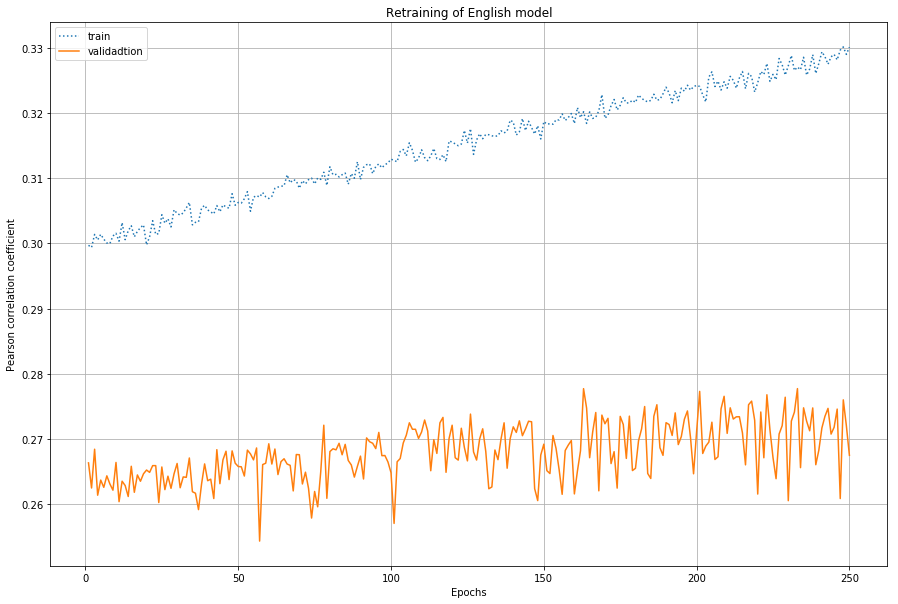

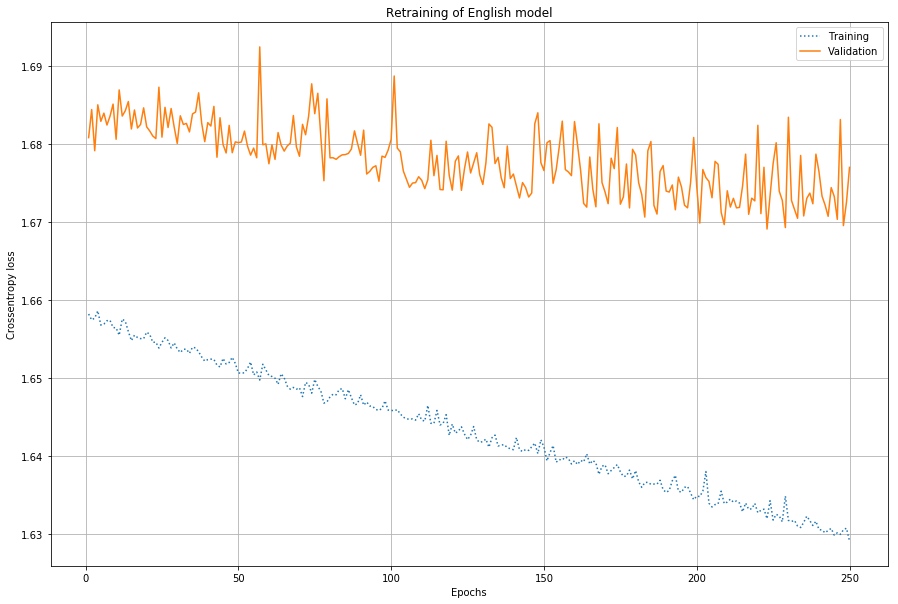

In [9]:
mpl.rcParams['figure.figsize'] = (15,10)

epochs = list(range(len(model_history.history['pearson_r'])))
acc = model_history.history['pearson_r']
val_acc = model_history.history['val_pearson_r']
plt.plot([e+1 for e in epochs], acc, linestyle=':', label=f'train')
plt.plot([e+1 for e in epochs], val_acc, label=f'validadtion')
plt.xlabel("Epochs")
plt.ylabel("Pearson correlation coefficient")
plt.title("Retraining of English model")
plt.legend()
plt.grid(b=True)
plt.savefig(f'{BASE_DIR}/en-model-retraining-output_pearson.png', bbox_inches='tight')

plt.figure()
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot([e+1 for e in epochs], loss, linestyle=':', label=f'Training')
plt.plot([e+1 for e in epochs], val_loss, label=f'Validation')
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.title('Retraining of English model')
plt.legend()
plt.grid(b=True)
plt.savefig(f'{BASE_DIR}/en-model-retraining-output_loss.png', bbox_inches='tight')
plt.show()


### Test the best model

In [10]:
best_model_path = f"{BASE_DIR}/weights/weights.epoch_233.valloss_1.67.valpearson_0.28.hdf5"
best_model = load_model(best_model_path, custom_objects={'pearson_r': pearson_r})
best_model.evaluate(x=val_data, y=val_labels, batch_size=5, verbose=1)

361/361 [==============================] - 5s 15ms/step


[1.6553607033230262, 0.28118863645192865]

In [11]:
best_model.evaluate(x=test_data, y=test_labels, batch_size=5, verbose=1)

350/350 [==============================] - 5s 14ms/step


[1.6880839909826006, 0.2559007978066802]